# Lab 5 Report

Prepared by Zech Wolf

## 1. Data preparation

I use the personal key indicators of heart disease dataset found on Kaggle. The data has a mix of continuous and categorical features, and contains over 300,000 instances. The target variable is "HeartDisease" which indicates whether or not a patient has experienced heart disease. This will be label encoded as 0 or 1.

There are 17 features in the dataset, both categorical and continuous. The categorical features will be label encoded as integers to support embedding. The continuous features will be processed through a standard scaler.

Dataset source: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease?resource=download

### 1.1 Preprocessing

In [1]:
import pandas as pd

df = pd.read_csv("datasets/heart_2020_cleaned.csv")

#Quality check
df.isna().any()

HeartDisease        False
BMI                 False
Smoking             False
AlcoholDrinking     False
Stroke              False
PhysicalHealth      False
MentalHealth        False
DiffWalking         False
Sex                 False
AgeCategory         False
Race                False
Diabetic            False
PhysicalActivity    False
GenHealth           False
SleepTime           False
Asthma              False
KidneyDisease       False
SkinCancer          False
dtype: bool

#### Feature summary

| __Feature__ | __Type__ | __Representation__ |
|----|----|----|
| BMI | continuous | float |
| Smoking | categorical | int |
| AlcoholDrinking | categorical | int |
| Stroke | categorical | int |
| PhysicalHealth | continuous | float |
| MentalHealth | continuous | float |
| DiffWalking | categorical | int |
| Sex | categorical | int |
| AgeCategory | ordinal | int |
| Race | categorical | int |
| Diabetic | categorical | int |
| PhysicalActivity | categorical | int |
| GenHealth | ordinal | int |
| SleepTime | continuous | float |
| Asthma | categorical | int |
| KidneyDisease | categorical | int |
| SkinCancer | categorical | int |
| HeartDisease (target) | categorical | int |

#### Undersampling

The dataset is highly imbalanced towards the negative class, so I equalize the number of instances per class by undersampling. Since there are about 27,000 instances of the positive class, the undersampled dataset will still have plenty of data to work with.

In [2]:
df_neg = df[df.HeartDisease == "No"]
df_pos = df[df.HeartDisease == "Yes"]

df = pd.concat([df_neg.sample(n=len(df_pos), random_state=1234), df_pos])

#### Label encoding

There are quite a few categorical and ordinal features given in string format. These need to be replaced with integers in order to create embeddings later on.

In [3]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

cat_columns = ["Smoking", "AlcoholDrinking", "Stroke", "DiffWalking",
                "Sex", "Race", "Diabetic", "PhysicalActivity", "Asthma",
                "KidneyDisease", "SkinCancer", "AgeCategory", "GenHealth"]

df.replace(to_replace=["Poor","Fair","Good","Very good","Excellent"],
            value=["1Poor","2Fair","3Good","4Very good","5Excellent"],
            inplace=True) #alphabetize genhealth so it works with label encoder

le = dict()

for col in cat_columns:
    enc = LabelEncoder()
    colname = f"{col}_lbl"
    df[colname] = enc.fit_transform(df[col])
    le[colname] = enc #store in dict with col name as key

cat_cols_lbl = [f"{col}_lbl" for col in cat_columns]

#Label encode target - doesnt need a new column
df["HeartDisease"] = LabelEncoder().fit_transform(df["HeartDisease"])

### 1.2 Cross product features

* Demographic features: AgeCategory, Sex, Race
* Habit features: Smoking, AlcoholDrinking, 

### 1.3 Evaluation metrics

This dataset is focused on helping to identify risk of heart disease. The target is a binary yes/no variable indicating whether a patient has experienced heart disease. In a potential business case, information about current patients could be used to predict if the patient is at risk of heart disease, and help physicians to recommend treatments and protocols based on the prediction.

In this case, it would be most important to have a high true positive rate, because there is a high cost for false negatives. If a patient is actually at risk but is misidentified as being not at risk, they might not get the proper treatment to mitigate the risk of heart disease. On the other hand, a false positive could mean that a patient is referred to treatment that is not strictly necessary. While this is not a preferable outcome, the cost is much less signficant than the cost of false negatives. Thus I will use recall as the evaluation metric, to optimize for identifying the highest proportion of the real positives while minimizing false negatives.

### 1.4 Train test split

The dataset is very large, with over 300,000 instances, so a stratified 80/20 split will work fine. Although the dataset is highly imbalanced towards the negative class, there are still nearly 30,000 instances of the positive class, meaning the model should still have a large number of positive instances to train on without needing to do any resampling. The class distribution in the testing set should resemble what would be expected of the class distribution in practice, so that the performance on the testing set is representative of how the model would perform in a real deployment. Assuming that the class distribution in reality will be similar to the distribution the dataset as a whole, we can stratify by class to preserve that distribution in both the training and testing sets.

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns="HeartDisease")
y = df["HeartDisease"].to_numpy()

df_train, df_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, test_size=0.2)

In [5]:
np.bincount(y)

array([27373, 27373])

#### Feature normalization

Scaling is done separately on training and testing sets

In [6]:
from sklearn.preprocessing import StandardScaler

numeric_cols = ["BMI", "PhysicalHealth", "MentalHealth", "SleepTime"]
scaler = StandardScaler()

for col in numeric_cols:
    df_train[col] = scaler.fit_transform(df_train[col].to_numpy().reshape(-1,1))
    df_test[col] = scaler.fit_transform(df_test[col].to_numpy().reshape(-1,1))

## 2. Modeling

#### Helper functions and preparation

In [16]:
def cross_features(col_lists):
    """Adds the crossed column to the df"""

    cross_col_df_names = list()

    for cols in col_lists:
        # encode as ints for the embedding
        enc = LabelEncoder()
        
        # 1. create crossed labels by join operation
        X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
        
        # get a nice name for this new crossed column
        cross_col_name = '_'.join(cols)
        
        # 2. encode as integers, stacking all possibilities
        enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
        
        # 3. Save into dataframe with new name
        df_train[cross_col_name] = enc.transform(X_crossed_train)
        df_test[cross_col_name] = enc.transform(X_crossed_test)
        
        # Save the encoder used here for later:
        le[cross_col_name] = enc
        
        # keep track of the new names of the crossed columns
        cross_col_df_names.append(cross_col_name)

    return cross_col_df_names

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate
from tensorflow.keras.models import Model

def get_wide_branch(cross_cols):
    """Build the wide branch of the network based on the given crossed columns"""
    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(len(cross_cols),), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names):
        
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = len(le[col].classes_)
        N_reduced = int(np.sqrt(N))
        
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
        
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                    output_dim=N_reduced, 
                    input_length=1, name=col+'_embed')(x)
        
        # save these outputs to concatenate later
        crossed_outputs.append(x)

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    return input_crossed, wide_branch

In [66]:
def get_deep_branch(layers=(50)):
    """
    Creates the deep branch of the network
    layers : tuple with the sizes of each layer

    Uses global arrays cat_cols_lbl and numeric_cols for reference
    """
    
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(len(cat_cols_lbl),), dtype='int64', name='categorical_input')
    for idx,col in enumerate(cat_cols_lbl):
        N = len(le[col].classes_)
        N_reduced = int(np.sqrt(N))
        
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
        
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                    output_dim=N_reduced, 
                    input_length=1, name=col+'_embed')(x)
        
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
        
    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(len(numeric_cols),), name='numeric')
    x_dense = Dense(units=20, activation='relu',name='num_1')(input_num)

    all_deep_branch_outputs.append(x_dense)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')

    for i,n in enumerate(layers):
        deep_branch = Dense(units=n,activation='relu', name=f'deep{i+1}')(deep_branch)

    return input_cat, input_num, deep_branch

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

def plot_performance(hist):
    plt.figure(figsize=(14,6))

    #Recall plot
    plt.subplot(1,2,1)
    epochs = range(len(hist.epoch))
    recall = hist.history["recall"]
    val_recall = hist.history["val_recall"]

    sns.lineplot(x=epochs, y=recall, label="Training recall")
    sns.lineplot(x=epochs, y=val_recall, label="Validation recall")

    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend()
    plt.title("Recall vs. Epoch")

    #Loss plot
    plt.subplot(1,2,2)
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]

    sns.lineplot(x=epochs, y=loss, label="Training loss")
    sns.lineplot(x=epochs, y=val_loss, label="Validation loss")

    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()


In [11]:
#These inputs wont change for now
X_train_cat = df_train[cat_cols_lbl].to_numpy() 
X_test_cat = df_test[cat_cols_lbl].to_numpy() 

X_train_num =  df_train[numeric_cols].to_numpy()
X_test_num = df_test[numeric_cols].to_numpy()

In [41]:
from sklearn.metrics import recall_score

def model_report(model, X_train_crossed, X_test_crossed):
    hist = model.fit([X_train_crossed, X_train_cat, X_train_num], y_train,
            epochs=50, batch_size=10000, verbose=0,
            validation_data=([X_test_crossed, X_test_cat,X_test_num], y_test))

    y_pred = model.predict([X_test_crossed, X_test_cat, X_test_num]) #crossed feature df will be changing so it needs to be passed in
    y_pred = np.round(y_pred)

    plot_performance(hist)
    print(f"Recall: {recall_score(y_test, y_pred)}")

### 2.1 Wide and deep networks

#### 2.1.1 Demographic feature crossing

This first network simply converts all the categorical features into separate embeddings, which are combined with a dense layer for the numeric features.

In [42]:
#Generate the wide and deep branches
cross_col_df_names = cross_features([ ["Sex", "AgeCategory", "Race"] ])
input_crossed, wide_branch = get_wide_branch(cross_col_df_names)
input_cat, input_num, deep_branch = get_deep_branch((50,))

# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                        name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                    name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
            outputs=final_branch)

model.compile(optimizer="adam",
              loss=[tf.keras.losses.BinaryCrossentropy()],
              metrics=["Recall"])

343/343 [==============================] - 2s 5ms/step


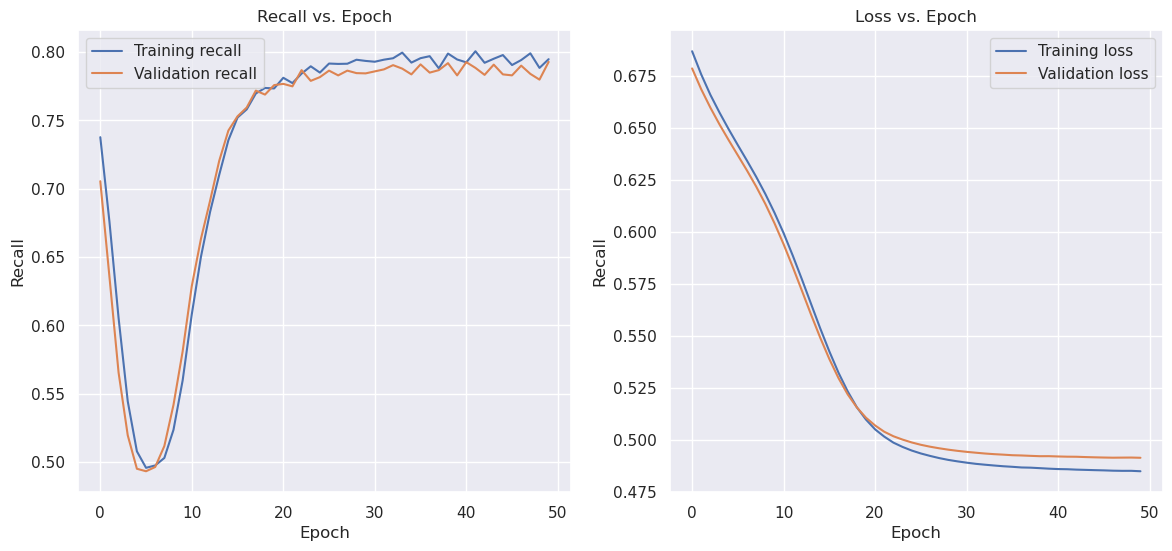

Recall: 0.7928767123287671


In [43]:
model_report(model, X_train_crossed, X_test_crossed)

#### 2.1.2 Demographics and habits cross columns

In [53]:
#Generate the wide and deep branches
cross_col_df_names = cross_features([ ["Sex", "AgeCategory", "Race"],
                                        ["AlcoholDrinking", "Smoking", "PhysicalActivity"] ])
input_crossed, wide_branch = get_wide_branch(cross_col_df_names)
input_cat, input_num, deep_branch = get_deep_branch((50,))

# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                        name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                    name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
            outputs=final_branch)

model.compile(optimizer="adam",
              loss=[tf.keras.losses.BinaryCrossentropy()],
              metrics=["Recall"])

343/343 [==============================] - 2s 6ms/step


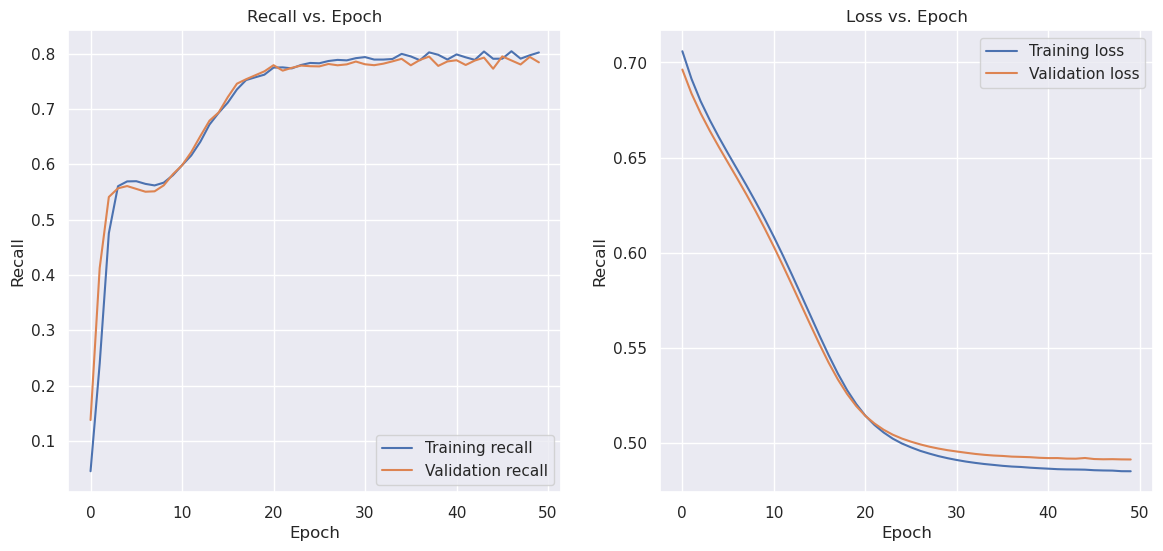

Recall: 0.7841095890410958


In [54]:
model_report(model, X_train_crossed, X_test_crossed)

#### 2.1.3 Demographic, habit, and health condition crossed columns

In [63]:
#Generate the wide branch
cross_col_df_names = cross_features([ ["Sex", "AgeCategory", "Race"],
                                        ["AlcoholDrinking", "Smoking", "PhysicalActivity"],
                                        ["Stroke","DiffWalking","Diabetic","Asthma","KidneyDisease","SkinCancer"] ])
input_crossed, wide_branch = get_wide_branch(cross_col_df_names)
input_cat, input_num, deep_branch = get_deep_branch((50,))

# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                        name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                    name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
            outputs=final_branch)

model.compile(optimizer="adam",
              loss=[tf.keras.losses.BinaryCrossentropy()],
              metrics=["Recall"])

343/343 [==============================] - 3s 7ms/step


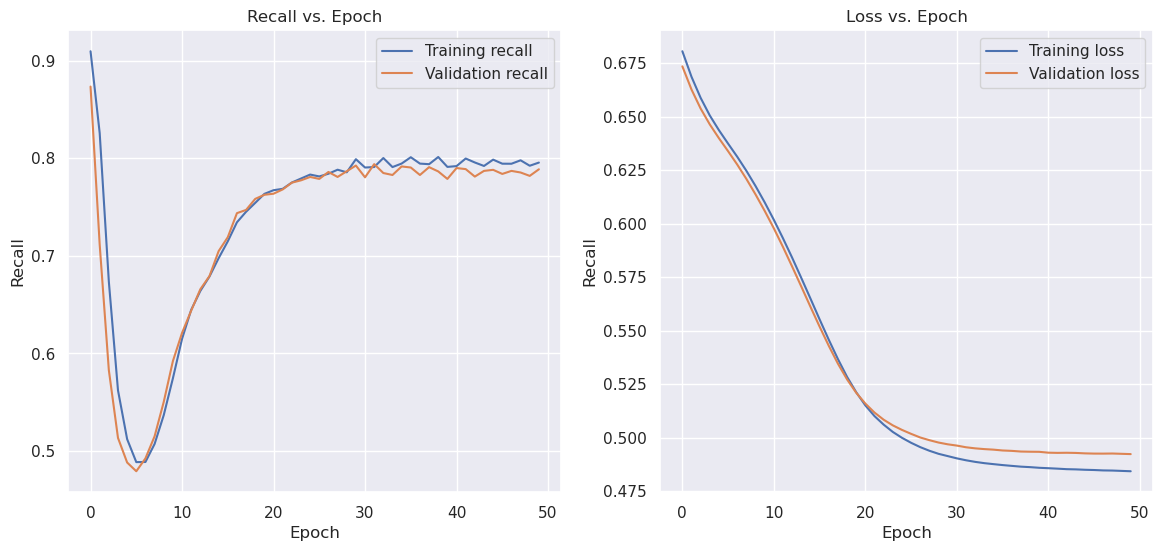

Recall: 0.788675799086758


In [64]:
model_report(model, X_train_crossed, X_test_crossed)

### 2.2 Effect of the number of layers in the deep branch

For this comparison, I use the wide and deep network with all three crossed columns, which was implemented with one layer in the deep branch in 2.1.3. For testing, I experiment with 2-6 layers in the deep branch.

In [70]:
layers = [(50,50), (50,50,25), (50,50,25,25), (50,50,25,25,12), (50,50,25,25,12,12)]
y_preds = list()

#Generate the wide branch -- same for all networks here
cross_col_df_names = cross_features([ ["Sex", "AgeCategory", "Race"],
                                        ["AlcoholDrinking", "Smoking", "PhysicalActivity"],
                                        ["Stroke","DiffWalking","Diabetic","Asthma","KidneyDisease","SkinCancer"] ])
input_crossed, wide_branch = get_wide_branch(cross_col_df_names)

# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

for l in layers:
    input_cat, input_num, deep_branch = get_deep_branch(l) #deep branch with specified layer structure

    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch],
                            name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid',
                        name='combined')(final_branch)

    model = Model(inputs=[input_crossed,input_cat,input_num], 
                outputs=final_branch)

    model.compile(optimizer="adam",
                loss=[tf.keras.losses.BinaryCrossentropy()],
                metrics=["Recall"])

    hist = model.fit([X_train_crossed, X_train_cat, X_train_num], y_train,
            epochs=50, batch_size=10000, verbose=0,
            validation_data=([X_test_crossed, X_test_cat,X_test_num], y_test))

    y_pred = model.predict([X_test_crossed, X_test_cat, X_test_num])
    y_preds.append(np.round(y_pred))

343/343 [==============================] - 2s 4ms/step


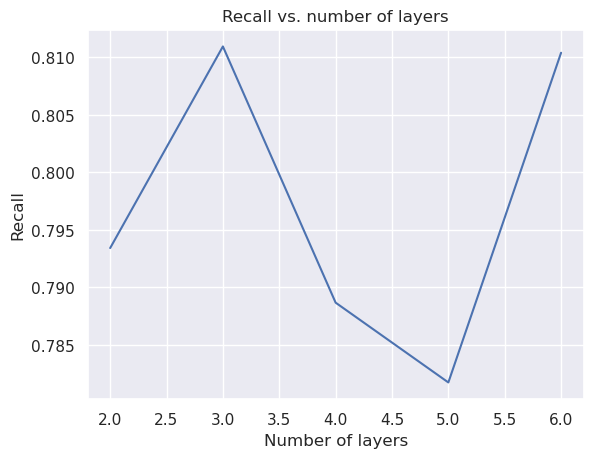

2 0.7934246575342466
3 0.810958904109589
4 0.788675799086758
5 0.7817351598173516
6 0.8104109589041096


In [75]:
recalls = [recall_score(y_test, yhat) for yhat in y_preds]
lcount = [len(l) for l in layers]

sns.lineplot(x=lcount, y=recalls)
plt.xlabel("Number of layers")
plt.ylabel("Recall")
plt.title("Recall vs. number of layers")
plt.show()

for i,r in enumerate(recalls):
    print(i+2, r)

Based on recall on the testing set, the network with a deep branch of 3 layers performs the best, by a slight margin over 6 layers

### 2.3 Wide and deep vs. deep only

The wide and deep network with 3 layers is compared with a network with only a deep branch. The deep branches are the same between both networks.

In [133]:
#Generate the wide branch
cross_col_df_names = cross_features([ ["Sex", "AgeCategory", "Race"],
                                        ["AlcoholDrinking", "Smoking", "PhysicalActivity"],
                                        ["Stroke","DiffWalking","Diabetic","Asthma","KidneyDisease","SkinCancer"] ])
input_crossed, wide_branch = get_wide_branch(cross_col_df_names)
input_cat, input_num, deep_branch = get_deep_branch((50,50,25))

# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                        name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                    name='combined')(final_branch)

model_wd = Model(inputs=[input_crossed,input_cat,input_num], 
            outputs=final_branch)

model_wd.compile(optimizer="adam",
              loss=[tf.keras.losses.BinaryCrossentropy()],
              metrics=["Recall"])

#Deep model
deep_output = Dense(units=1, activation="sigmoid", name="deep_out")(deep_branch)
model_d = Model(inputs=[input_cat,input_num], outputs=deep_output)
model_d.compile(optimizer="adam",
              loss=[tf.keras.losses.BinaryCrossentropy()],
              metrics=["Recall"])

In [134]:
hist_wd = model_wd.fit([X_train_crossed, X_train_cat, X_train_num], y_train,
            epochs=50, batch_size=10000, verbose=0,
            validation_data=([X_test_crossed, X_test_cat,X_test_num], y_test))

hist_d = model_d.fit([X_train_cat, X_train_num], y_train,
            epochs=50, batch_size=10000, verbose=0,
            validation_data=([X_test_cat,X_test_num], y_test))

In [135]:
y_prob_wd = model_wd.predict([X_test_crossed, X_test_cat, X_test_num])
y_prob_d = model_d.predict([X_test_cat, X_test_num])
y_pred_wd = np.round(y_prob_wd)
y_pred_d = np.round(y_prob_d)

343/343 [==============================] - 2s 7ms/step


#### ROC Curve

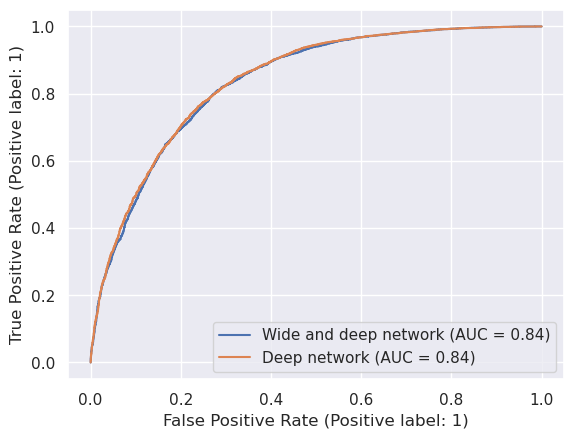

In [142]:
from sklearn.metrics import RocCurveDisplay

fig = RocCurveDisplay.from_predictions(y_test, y_prob_wd, name="Wide and deep network")
RocCurveDisplay.from_predictions(y_test, y_prob_d, ax=fig.ax_, name="Deep network")
plt.show()

Both models have the same AUC. The curves are also very similar in structure, so it is difficult to say if one is preferable based on true positive rate. For a final comparison, McNemar's test should be used, and if there is a statistical difference, the model with the higher recall score on the test set is preferable.

#### McNemar's test

The critical value for a 95% confidence interval is $3.841$ for McNemar's test. If the test result exceeds this value, then there is a statistically significant difference between the two neural networks

In [143]:
def get_contingency(yhat1, yhat2, y):
    """Generate the contingency matrix """
    contingency = np.zeros((2,2))
    for i in range(len(y)): #slow but it works
        if yhat1[i] == y[i] and yhat2[i] == y[i]: #A
            contingency[0,0] += 1
        elif yhat1[i] == y[i] and yhat2[i] != y[i]: #B
            contingency[0,1] += 1
        elif yhat1[i] != y[i] and yhat2[i] == y[i]: #C
            contingency[1,0] += 1
        elif yhat1[i] != y[i] and yhat2[i] != y[i]: #D
            contingency[1,1] += 1

    return contingency

def mcnemar(yhat1, yhat2, y):
    """Get the chi2 value for McNemar's test"""
    contingency = get_contingency(yhat1, yhat2, y)
    B = contingency[0,1]
    C = contingency[1,0]

    return ((np.abs(B-C) - 1)**2) / (B + C)

In [144]:
p = mcnemar(y_pred_wd, y_pred_d, y_test)
print("Wide and deep vs. deep only:", p)

Wide and deep vs. deep only: 64.01515151515152


The resulting p-value is much larger than the critical value, so we can say with 95% confidence that there is a statistically significant difference between the two networks. The network with the better recall score is thus the better model. Additonally, comparing the confusion matrices for each model will help visualize what the difference in recall means for the performance.

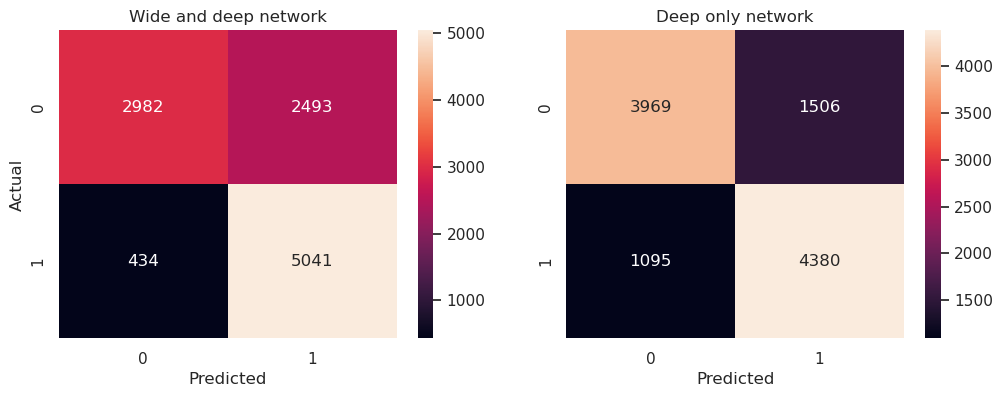

In [156]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred_wd), annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Wide and deep network")

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_d), annot=True, fmt="d")
plt.xlabel("Predicted")
plt.title("Deep only network")
plt.show()

In [146]:
print("Wide and deep recall:", recall_score(y_test, y_pred_wd))
print("Deep only recall:", recall_score(y_test, y_pred_d))

Wide and deep recall: 0.9207305936073059
Deep only recall: 0.8


The wide and deep network has the higher recall, with a score of about 0.92. The confusion matrices show that this means the wide and deep network is much better at identifying true positives, and minimizing false negatives. From this, we can conclude that the wide and deep network is the better model according to the performance metric for this task.